In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import PIL.Image as Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import models,transforms
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device)

cuda


In [3]:
path = "/kaggle/input/aptos2019-blindness-detection/"
train_df = pd.read_csv(f"{path}train.csv")
print(f'No.of.training_samples: {len(train_df)}')

No.of.training_samples: 3662


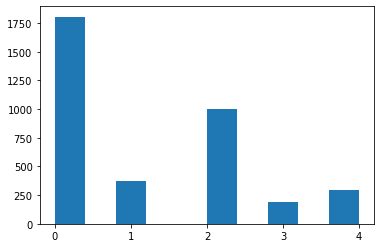

In [4]:
#Histogram of label counts.
train_df.diagnosis.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show() 

In [5]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['diagnosis'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
print(class_weights) 

tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827], device='cuda:0')


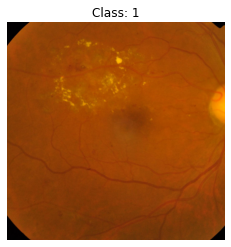

In [6]:
path = "/kaggle/input/dr-aptos2019-preprocessed/"
num = int(np.random.randint(0,len(train_df)-1,(1,))) #Picks a random number.
sample_image = (f'{path}train_images/{train_df["id_code"][num]}.png')#Image file.
sample_image = Image.open(sample_image) 
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Class: {train_df["diagnosis"][num]}') #Class of the random image.
plt.show()

In [7]:
def one_hot(x):
    return torch.eye(5)[x,:]

In [8]:
class dataset(Dataset):
    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.
    
    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.
        
        if self.train :
            label = one_hot(self.df['diagnosis'][index]) #Label.
            return image,label #If train == True, return image & label.
        
        else:
            return image #If train != True, return image.
            

In [9]:
path="/kaggle/input/dr-aptos2019-preprocessed/"
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                     # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Transformations to apply to the image.
data_set = dataset(train_df,f'{path}train_images',image_transform=image_transform)

train_set,valid_set = torch.utils.data.random_split(data_set,[3302,360],generator=torch.Generator().manual_seed(989))

In [10]:
train_dataloader = DataLoader(train_set,batch_size=16,shuffle=True) #DataLoader for train_set.
valid_dataloader = DataLoader(valid_set,batch_size=16,shuffle=False) #DataLoader for validation_set.

In [11]:
model = models.resnet50()
model.fc=nn.Sequential(nn.Linear(2048,5),nn.Sigmoid())
model = model.to(device)

In [12]:
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score

def validate():
    model.eval()
    total = 0
    correct = 0
    running_loss = 0
    pred_lst = []
    gt_lst = []
    with torch.no_grad():
        for x,y in valid_dataloader:
            output= model(x.to(device)) #model's output.
            output=output.detach().cpu().numpy()
            #print(output)
            pred_lst.append(output)
            gt_lst.append(y)
            del x, y, output
            
        
        pred_lst=np.concatenate(pred_lst, axis=0)
        gt_lst=np.concatenate(gt_lst, axis=0)
        #print(pred_lst)
        #for i in range(len(gt_lst)):                     
            #print(np.mean(pred_lst[i][0],axis=0))
            #print(np.sum(pred_lst,axis=0))
        pred_lst2 = np.argmax(pred_lst, axis=1)
        #print(pred_lst2)
        #print("\n")
        gt_lst2 = np.argmax(gt_lst, axis=1)
        auc_lst=[]
        acc_lst=[]
        for k in range(0,5):
            tmp_gt=gt_lst[:, k]
            tmp_pred=pred_lst[:,k]
            tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
            acc_lst.append(tmp_acc)
            tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
            auc_lst.append(tmp_auc)

        auc_lst=np.array(auc_lst)
        acc_lst=np.array(acc_lst)
        print('AUC Classwise Score on Validation set = ', auc_lst)
        print('ACC Classwise Score on Validation set = ', acc_lst)
        auc=np.mean(auc_lst)
        acc = np.mean(acc_lst)
        print('AUC Score on Validation set = ', auc)
        print('ACC Score on Validation set = ', acc)
        f1 = f1_score(gt_lst2, pred_lst2, average='weighted')
        print('F1 Score on Validation set = ', f1)
        cohen_kappa = cohen_kappa_score(gt_lst2, pred_lst2,weights="quadratic")
        print("Cohen's Kappa Score on Validation set = ", cohen_kappa)
        print(classification_report(gt_lst2, pred_lst2, labels=[0,1, 2, 3,4]))
        model.train()
        return auc,acc,f1,cohen_kappa

In [13]:
def train():
    total_batches=len(train_dataloader)
    cycle_length= len(train_dataloader)*2
    loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss
    optimizer = torch.optim.SGD(model.parameters(),lr=0.001) 
    model.train()
    total = 0
    correct = 0
    running_loss=0
    count=0
    max_epochs=50
    
    
    for epoch in range(0, max_epochs):
        for batch,(x,y) in enumerate(train_dataloader):
            output = model(x.to(device)) #model's predictions.
            y=y.long()
            loss   = loss_fn(output,torch.max(y.to(device), 1)[1])
            running_loss=running_loss+loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (batch+1) % 25 == 0: # displays after every 20 batches
                    print ("Epoch [{}/{}], Batch [{}/{}] Classification Loss: {:.4f}".format(epoch+1, max_epochs, batch+1, total_batches, running_loss/(batch+1) ), end ="\r")
                    
            count=count+1
            if count>=cycle_length:
                count=0
                auc,acc,f1,cohen_kappa=validate()
                auc=np.round(auc,4)
                nm='DR_CNN_Model_RESENET50.pt_'+str(cohen_kappa)
                torch.save({'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict()}, nm)
                del nm
                running_loss=0
                
    return model

In [14]:
model=train()

AUC Classwise Score on Validation set =  [0.73697682 0.66847963 0.47783929 0.7021057  0.62618884]
ACC Classwise Score on Validation set =  [0.68333333 0.66944444 0.67222222 0.96111111 0.91388889]
AUC Score on Validation set =  0.6423180547145821
ACC Score on Validation set =  0.78
F1 Score on Validation set =  0.3536966891133557
Cohen's Kappa Score on Validation set =  0.16296674577187653
              precision    recall  f1-score   support

           0       0.61      0.84      0.71       167
           1       0.16      0.57      0.25        37
           2       0.00      0.00      0.00       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.45       360
   macro avg       0.15      0.28      0.19       360
weighted avg       0.30      0.45      0.35       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.83930067 0.75366078 0.66123955 0.74421965 0.65138739]
ACC Classwise Score on Validation set =  [0.77222222 0.875      0.69166667 0.96111111 0.91388889]
AUC Score on Validation set =  0.729961610339023
ACC Score on Validation set =  0.8427777777777777
F1 Score on Validation set =  0.4947434313652822
Cohen's Kappa Score on Validation set =  0.29637637291360364
              precision    recall  f1-score   support

           0       0.65      0.89      0.75       167
           1       0.26      0.49      0.34        37
           2       0.49      0.28      0.36       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.55       360
   macro avg       0.28      0.33      0.29       360
weighted avg       0.48      0.55      0.49       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.84721231 0.73408083 0.7034625  0.73926507 0.67668399]
ACC Classwise Score on Validation set =  [0.8        0.63888889 0.68333333 0.96111111 0.89166667]
AUC Score on Validation set =  0.7401409397289166
ACC Score on Validation set =  0.795
F1 Score on Validation set =  0.42525915273996934
Cohen's Kappa Score on Validation set =  0.27543966819920906
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       167
           1       0.18      0.78      0.29        37
           2       0.40      0.07      0.12       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.47       360
   macro avg       0.27      0.33      0.24       360
weighted avg       0.49      0.47      0.43       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.88162018 0.75684043 0.73027244 0.76300578 0.67452691]
ACC Classwise Score on Validation set =  [0.83611111 0.65555556 0.68333333 0.96111111 0.77222222]
AUC Score on Validation set =  0.7612531493918997
ACC Score on Validation set =  0.7816666666666666
F1 Score on Validation set =  0.48329131893290084
Cohen's Kappa Score on Validation set =  0.3572858095873438
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       167
           1       0.20      0.78      0.32        37
           2       0.38      0.16      0.23       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.51       360
   macro avg       0.28      0.35      0.27       360
weighted avg       0.52      0.51      0.48       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.91363904 0.78261233 0.74604725 0.75743187 0.68090009]
ACC Classwise Score on Validation set =  [0.85       0.64166667 0.69722222 0.86388889 0.65      ]
AUC Score on Validation set =  0.7761261183304651
ACC Score on Validation set =  0.7405555555555556
F1 Score on Validation set =  0.5183616654348362
Cohen's Kappa Score on Validation set =  0.3572838036771384
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       167
           1       0.21      0.73      0.33        37
           2       0.42      0.26      0.32       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.54       360
   macro avg       0.29      0.36      0.30       360
weighted avg       0.54      0.54      0.52       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.92009246 0.78219396 0.75111256 0.776218   0.68756741]
ACC Classwise Score on Validation set =  [0.85833333 0.64444444 0.68055556 0.71111111 0.59166667]
AUC Score on Validation set =  0.7834368769597837
ACC Score on Validation set =  0.6972222222222223
F1 Score on Validation set =  0.5992287748993111
Cohen's Kappa Score on Validation set =  0.5194028945052944
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       167
           1       0.30      0.59      0.40        37
           2       0.51      0.56      0.53       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.62       360
   macro avg       0.33      0.40      0.36       360
weighted avg       0.58      0.62      0.60       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.91320468 0.77725713 0.74709649 0.77931462 0.69384253]
ACC Classwise Score on Validation set =  [0.86111111 0.62777778 0.675      0.64166667 0.57777778]
AUC Score on Validation set =  0.7821430911411447
ACC Score on Validation set =  0.6766666666666665
F1 Score on Validation set =  0.5929983202550617
Cohen's Kappa Score on Validation set =  0.49297313704659274
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       167
           1       0.30      0.62      0.40        37
           2       0.50      0.52      0.51       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.62       360
   macro avg       0.33      0.40      0.35       360
weighted avg       0.58      0.62      0.59       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.92685613 0.78361643 0.76160498 0.78550784 0.6843318 ]
ACC Classwise Score on Validation set =  [0.85833333 0.64444444 0.68333333 0.69722222 0.56944444]
AUC Score on Validation set =  0.7883834373060198
ACC Score on Validation set =  0.6905555555555555
F1 Score on Validation set =  0.6097834099310476
Cohen's Kappa Score on Validation set =  0.5334866083425398
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       167
           1       0.33      0.46      0.39        37
           2       0.51      0.66      0.57       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.64       360
   macro avg       0.34      0.39      0.36       360
weighted avg       0.59      0.64      0.61       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.91401136 0.78880428 0.74872463 0.78654005 0.68511619]
ACC Classwise Score on Validation set =  [0.85833333 0.64444444 0.68055556 0.57222222 0.56388889]
AUC Score on Validation set =  0.784639301067539
ACC Score on Validation set =  0.663888888888889
F1 Score on Validation set =  0.6108971699852508
Cohen's Kappa Score on Validation set =  0.5488161745144986
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       167
           1       0.35      0.41      0.38        37
           2       0.51      0.67      0.58       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.65       360
   macro avg       0.34      0.39      0.36       360
weighted avg       0.58      0.65      0.61       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.93206851 0.78110618 0.77177177 0.77704377 0.68482204]
ACC Classwise Score on Validation set =  [0.88333333 0.63055556 0.71111111 0.51666667 0.56666667]
AUC Score on Validation set =  0.7893624535381015
ACC Score on Validation set =  0.6616666666666667
F1 Score on Validation set =  0.6450483419465978
Cohen's Kappa Score on Validation set =  0.5661768976131019
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       167
           1       0.37      0.38      0.37        37
           2       0.57      0.76      0.65       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.68       360
   macro avg       0.36      0.40      0.38       360
weighted avg       0.62      0.68      0.65       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.93244082 0.79131453 0.7653316  0.79644922 0.68786156]
ACC Classwise Score on Validation set =  [0.87777778 0.65277778 0.7        0.51111111 0.575     ]
AUC Score on Validation set =  0.7946795438860876
ACC Score on Validation set =  0.6633333333333333
F1 Score on Validation set =  0.6296767504680147
Cohen's Kappa Score on Validation set =  0.5730022731246721
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       167
           1       0.35      0.30      0.32        37
           2       0.54      0.76      0.63       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.67       360
   macro avg       0.35      0.39      0.36       360
weighted avg       0.60      0.67      0.63       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.93535726 0.77801021 0.77578784 0.78406276 0.67884106]
ACC Classwise Score on Validation set =  [0.89166667 0.65277778 0.72777778 0.55       0.55833333]
AUC Score on Validation set =  0.7904118260050366
ACC Score on Validation set =  0.6761111111111111
F1 Score on Validation set =  0.6443013482405655
Cohen's Kappa Score on Validation set =  0.6111611161116113
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       167
           1       0.38      0.22      0.28        37
           2       0.56      0.82      0.66       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.70       360
   macro avg       0.36      0.39      0.37       360
weighted avg       0.61      0.70      0.64       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.93157209 0.76914066 0.77730743 0.78901734 0.69335229]
ACC Classwise Score on Validation set =  [0.89444444 0.65       0.72222222 0.54722222 0.57222222]
AUC Score on Validation set =  0.7920779610117294
ACC Score on Validation set =  0.6772222222222222
F1 Score on Validation set =  0.6463093941606131
Cohen's Kappa Score on Validation set =  0.6039696167166264
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       167
           1       0.38      0.32      0.35        37
           2       0.56      0.75      0.64       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.69       360
   macro avg       0.36      0.40      0.38       360
weighted avg       0.61      0.69      0.65       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.93833576 0.77968371 0.78269836 0.76527663 0.67482106]
ACC Classwise Score on Validation set =  [0.89444444 0.65833333 0.72222222 0.51388889 0.56111111]
AUC Score on Validation set =  0.7881631049931062
ACC Score on Validation set =  0.6699999999999999
F1 Score on Validation set =  0.6529364413601431
Cohen's Kappa Score on Validation set =  0.6270908216115247
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       167
           1       0.70      0.19      0.30        37
           2       0.57      0.86      0.68       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.71       360
   macro avg       0.43      0.39      0.37       360
weighted avg       0.65      0.71      0.65       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.94140734 0.77257133 0.78400087 0.79128819 0.69413668]
ACC Classwise Score on Validation set =  [0.9        0.65833333 0.72777778 0.52777778 0.55277778]
AUC Score on Validation set =  0.7966808827367693
ACC Score on Validation set =  0.6733333333333332
F1 Score on Validation set =  0.6437232881181422
Cohen's Kappa Score on Validation set =  0.6155103421067463
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       167
           1       0.41      0.19      0.26        37
           2       0.56      0.79      0.65       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.69       360
   macro avg       0.37      0.38      0.36       360
weighted avg       0.62      0.69      0.64       360

AUC Classwise Score on Validation set =  [0.93591573 0.77742448 0.77412352 0.78798514 0.68727326]
ACC Clas

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.93219261 0.77717346 0.76797279 0.78612717 0.69511717]
ACC Classwise Score on Validation set =  [0.89444444 0.64166667 0.72222222 0.50833333 0.56388889]
AUC Score on Validation set =  0.7917166391873074
ACC Score on Validation set =  0.6661111111111111
F1 Score on Validation set =  0.6387725576451203
Cohen's Kappa Score on Validation set =  0.5954943957385417
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       167
           1       0.47      0.22      0.30        37
           2       0.55      0.77      0.64       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.68       360
   macro avg       0.38      0.38      0.36       360
weighted avg       0.62      0.68      0.64       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.93886321 0.77516526 0.7751004  0.80016515 0.69933327]
ACC Classwise Score on Validation set =  [0.90277778 0.66944444 0.725      0.51944444 0.55833333]
AUC Score on Validation set =  0.7977254573415207
ACC Score on Validation set =  0.675
F1 Score on Validation set =  0.6605398677558879
Cohen's Kappa Score on Validation set =  0.6277454176241115
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       167
           1       0.64      0.19      0.29        37
           2       0.60      0.78      0.68       111
           3       0.07      0.14      0.09        14
           4       0.00      0.00      0.00        31

    accuracy                           0.69       360
   macro avg       0.44      0.41      0.39       360
weighted avg       0.66      0.69      0.66       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.94649561 0.76955903 0.78830638 0.79293972 0.69060692]
ACC Classwise Score on Validation set =  [0.90555556 0.67222222 0.72777778 0.53055556 0.56111111]
AUC Score on Validation set =  0.7975815325377928
ACC Score on Validation set =  0.6794444444444444
F1 Score on Validation set =  0.6575732164143271
Cohen's Kappa Score on Validation set =  0.6601150115869883
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       167
           1       0.70      0.19      0.30        37
           2       0.56      0.86      0.68       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.71       360
   macro avg       0.43      0.40      0.38       360
weighted avg       0.65      0.71      0.66       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.94666625 0.77114886 0.78599081 0.79025599 0.70158839]
ACC Classwise Score on Validation set =  [0.89722222 0.65833333 0.72777778 0.53611111 0.56944444]
AUC Score on Validation set =  0.7991300597432243
ACC Score on Validation set =  0.6777777777777777
F1 Score on Validation set =  0.6568045491143316
Cohen's Kappa Score on Validation set =  0.6284111335040035
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       167
           1       0.64      0.19      0.29        37
           2       0.58      0.78      0.67       111
           3       0.10      0.14      0.11        14
           4       0.00      0.00      0.00        31

    accuracy                           0.70       360
   macro avg       0.44      0.41      0.39       360
weighted avg       0.65      0.70      0.66       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.94056964 0.77073048 0.78059988 0.79273328 0.69570546]
ACC Classwise Score on Validation set =  [0.9        0.66944444 0.74166667 0.53611111 0.56666667]
AUC Score on Validation set =  0.7960677474637148
ACC Score on Validation set =  0.6827777777777777
F1 Score on Validation set =  0.6518389556180254
Cohen's Kappa Score on Validation set =  0.6244722245218975
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       167
           1       1.00      0.16      0.28        37
           2       0.57      0.83      0.67       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.70       360
   macro avg       0.49      0.38      0.37       360
weighted avg       0.68      0.70      0.65       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.932658   0.76872228 0.77188031 0.8014038  0.70266693]
ACC Classwise Score on Validation set =  [0.90555556 0.66666667 0.72777778 0.53055556 0.57222222]
AUC Score on Validation set =  0.7954662646818093
ACC Score on Validation set =  0.6805555555555556
F1 Score on Validation set =  0.6540900275173199
Cohen's Kappa Score on Validation set =  0.6835457441966318
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       167
           1       0.86      0.16      0.27        37
           2       0.55      0.85      0.67       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.71       360
   macro avg       0.46      0.39      0.37       360
weighted avg       0.66      0.71      0.65       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.94430827 0.77123253 0.78740186 0.79479769 0.70011766]
ACC Classwise Score on Validation set =  [0.90277778 0.67222222 0.73611111 0.53333333 0.56388889]
AUC Score on Validation set =  0.7995716027262267
ACC Score on Validation set =  0.6816666666666666
F1 Score on Validation set =  0.6544874065738657
Cohen's Kappa Score on Validation set =  0.6628816553116326
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       167
           1       1.00      0.16      0.28        37
           2       0.56      0.85      0.67       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.71       360
   macro avg       0.49      0.39      0.37       360
weighted avg       0.68      0.71      0.65       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.93929757 0.76202828 0.78258982 0.79521057 0.70237278]
ACC Classwise Score on Validation set =  [0.91111111 0.675      0.73611111 0.51111111 0.56388889]
AUC Score on Validation set =  0.7962998045941212
ACC Score on Validation set =  0.6794444444444444
F1 Score on Validation set =  0.6547218066699912
Cohen's Kappa Score on Validation set =  0.6595463917525773
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       167
           1       1.00      0.16      0.28        37
           2       0.56      0.82      0.67       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.70       360
   macro avg       0.49      0.38      0.37       360
weighted avg       0.69      0.70      0.65       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.94571996 0.77273868 0.78823402 0.78303055 0.69943132]
ACC Classwise Score on Validation set =  [0.90555556 0.66388889 0.725      0.51666667 0.55277778]
AUC Score on Validation set =  0.7978309058416504
ACC Score on Validation set =  0.6727777777777778
F1 Score on Validation set =  0.6530744410567902
Cohen's Kappa Score on Validation set =  0.6398640996602492
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       167
           1       0.86      0.16      0.27        37
           2       0.57      0.79      0.66       111
           3       0.08      0.14      0.10        14
           4       0.00      0.00      0.00        31

    accuracy                           0.69       360
   macro avg       0.48      0.40      0.39       360
weighted avg       0.68      0.69      0.65       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
